In [1]:
import pandas as pd
from scipy import stats
from utils import create_connection, calculate_distance
import numpy as np
import pickle as pkl
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import json
from shapely.geometry import Polygon, Point

# Load the Data Set for Seattle

In [2]:
# Connect to the database
df = pd.read_csv('./data/sea_cleaned.csv')
df.head()

,rent,beds,baths,sqft,fitness_center,air_conditioning,in_unit_washer_dryer,laundry_facilities,car_charging,roof,...,elevator,garage,dogs_allowed,cats_allowed,income_restrictions,dishwasher,price/sqft,dist_seattle,dist_transit,cluster_id
0,680.0,1,0.5,162.0,0,0,1,0,0,0,...,0,0,0,1,0,1.0,4.197531,3.932519,0.122959,2
1,645.0,0,1.0,148.0,0,0,0,1,0,0,...,1,0,0,0,0,0.0,4.358108,0.605872,0.075464,22
2,645.0,0,1.0,146.0,0,0,0,1,0,0,...,1,0,0,0,0,0.0,4.417808,0.605872,0.075464,22
3,645.0,0,1.0,115.0,0,0,0,1,0,0,...,1,0,0,0,0,0.0,5.608696,0.605872,0.075464,22
4,900.0,0,0.0,174.0,0,0,0,1,0,0,...,0,0,0,0,0,0.0,5.172414,4.353582,0.076268,4


# Visualization

### SQFT versus Rent

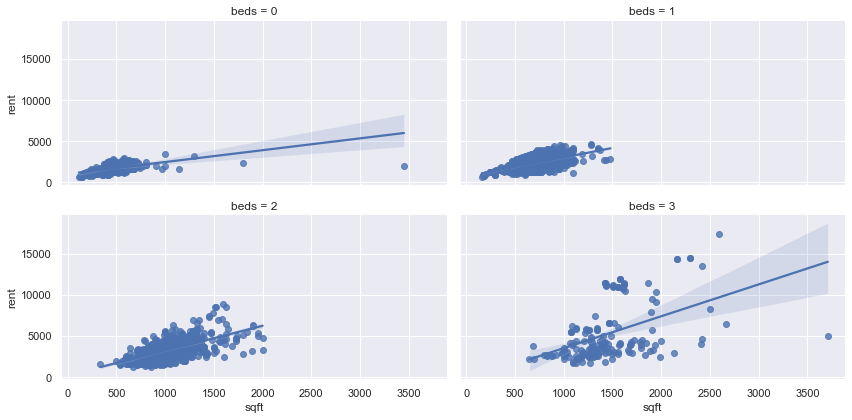

In [3]:
# Plot rent versus sqft for each bedroom size
g = sns.FacetGrid(df[df.beds<4], col='beds', col_wrap = 2, aspect = 2)
g.map(sns.regplot,'sqft','rent')

In [4]:
# Drop all studio units that have more than 1,000sqft
df.drop(df[(df.sqft>1000) & (df.beds==0)].index, inplace=True)

In [5]:
# Add a price/sqft column that will be useful for visualization
df['price/sqft'] = df.rent / df.sqft

### Transit versus Rent

In [6]:
# Visualize the relationship between price/sqft and distance to MTA stops

def transit_distance_plot(df):
 
    # Create distance bins based on distance to MTA stops
    # Look at binning for every 1/8th of a mile
    bins = np.arange(0.00, 0.3, 0.05)
    labels = bins[1:]
    df.loc[:,'transit_dist_bin'] = pd.cut(df.loc[:,"dist_transit"], bins=bins, labels=labels)
    
    # Create the boxplots
    plt.figure()
    sns.boxplot(x = 'transit_dist_bin', y = 'price/sqft', data = df)
    plt.ylim(0,10)
    plt.show()
    plt.close()
    

/opt/anaconda3/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


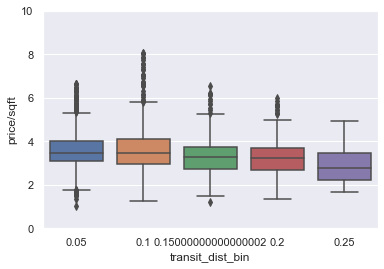

In [7]:
transit_distance_plot(df.copy())

### Plot Binary Features

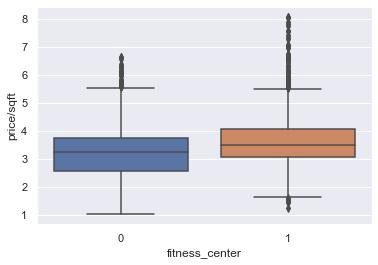

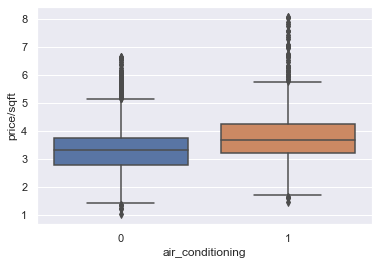

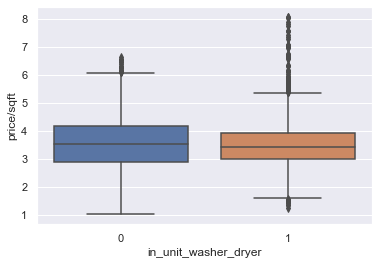

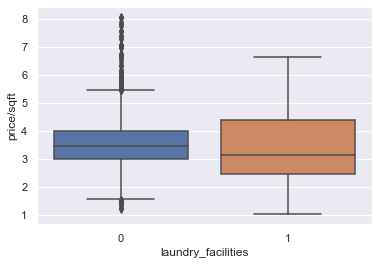

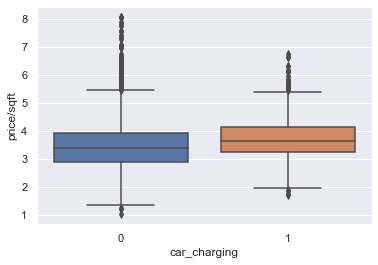

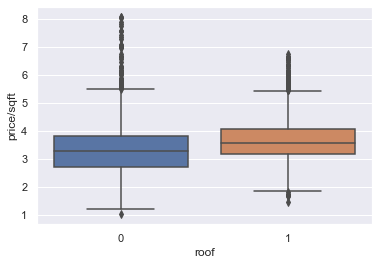

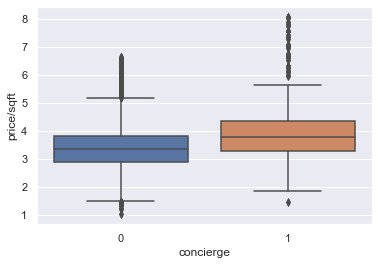

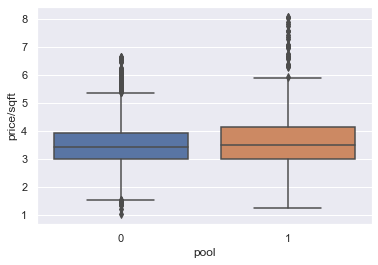

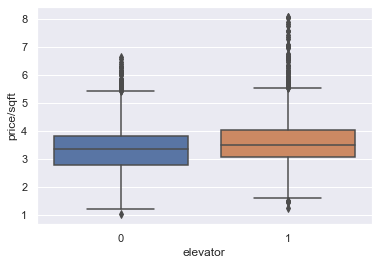

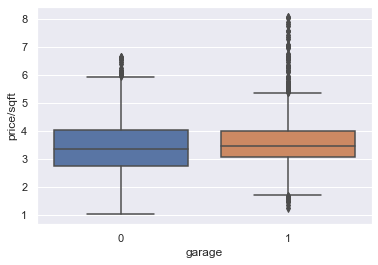

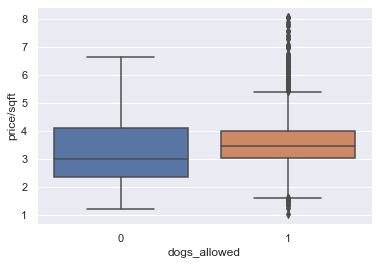

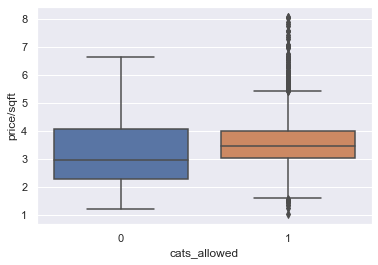

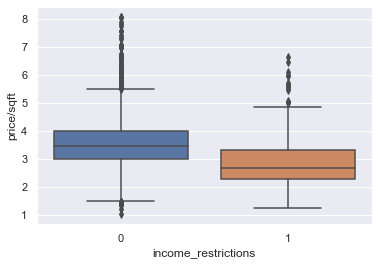

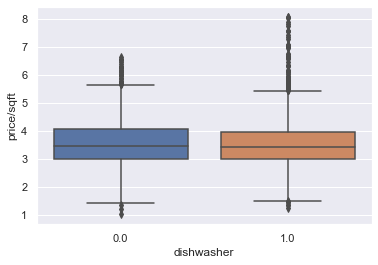

In [8]:
#plotting binary features
for i in df.columns[4:18]:
  plt.figure()
  sns.boxplot(x = i, y = 'price/sqft', data = df)
  plt.show()
  plt.close()

## Create new features from existing features

In [9]:
# Compute the mean rent/sqft for each cluster and drop the cluster_id
cluster_rent_per_sqft = df.groupby('cluster_id')['price/sqft'].mean().to_dict()
df['cluster_rent_per_sqft'] = df.cluster_id.map(cluster_rent_per_sqft)
df.drop(columns={'cluster_id'}, inplace=True)

# Create two different columns that blend beds and baths together
df['beds_plus_baths'] = df.beds+df.baths
df['beds_times_baths'] = df.beds*df.baths

<AxesSubplot:>

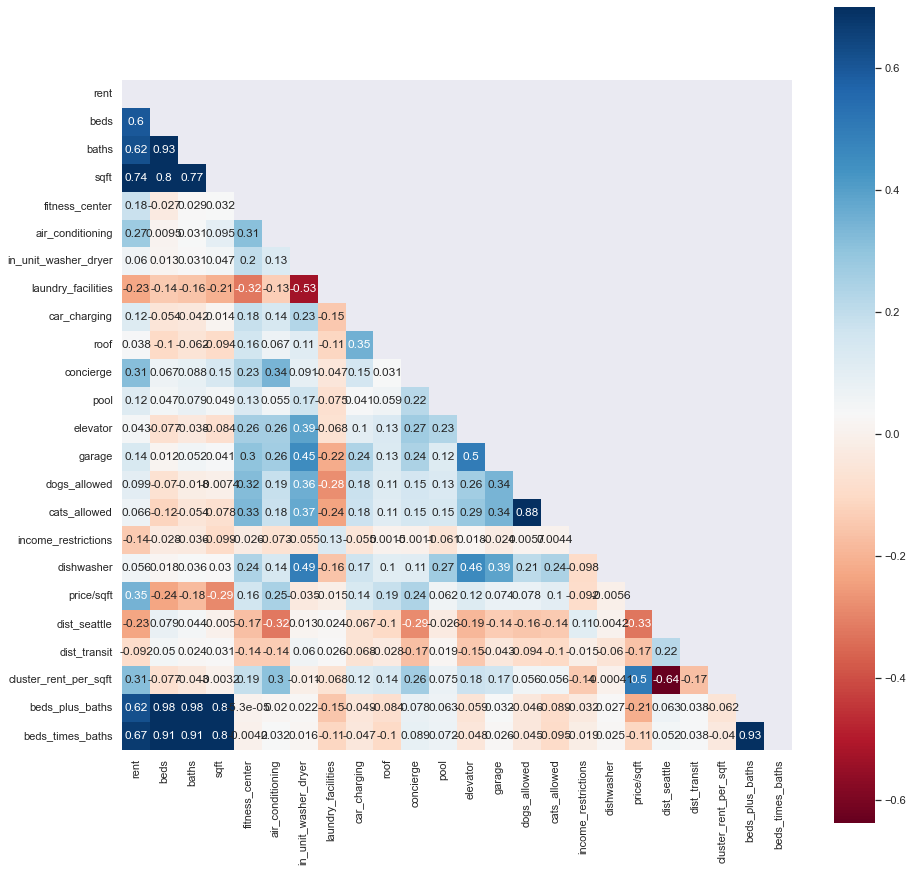

In [10]:
corr_map = df.corr()

# Create a mask
mask = np.triu(np.ones_like(corr_map, dtype=bool))

f,ax = plt.subplots(figsize = (15,15))
sns.heatmap(corr_map, square = True, vmax = 0.7, cmap = 'RdBu', annot = True, mask = mask)

The following updates to the dataset seem necessary to consolidate similar features:
* Combine dogs and cats into a single pet category
* Use beds_times_baths as a single feature since it appears to have a stronger correlation than the other combinations of beds and baths

In [11]:
# Create new pets category
df['pets_allowed']=np.where((df.dogs_allowed == 1) | (df.cats_allowed == 1),
                               1,
                               0)

# Drop columns
df.drop(columns={'dogs_allowed', 'cats_allowed', 'beds', 'baths', 'beds_plus_baths'}, inplace=True)

# Data processing

In [12]:
df.drop(columns={'price/sqft'}, inplace=True)
df.head()

,rent,sqft,fitness_center,air_conditioning,in_unit_washer_dryer,laundry_facilities,car_charging,roof,concierge,pool,elevator,garage,income_restrictions,dishwasher,dist_seattle,dist_transit,cluster_rent_per_sqft,beds_times_baths,pets_allowed
0,680.0,162.0,0,0,1,0,0,0,0,0,0,0,0,1.0,3.932519,0.122959,3.829163,0.5,1
1,645.0,148.0,0,0,0,1,0,0,0,0,1,0,0,0.0,0.605872,0.075464,3.351396,0.0,0
2,645.0,146.0,0,0,0,1,0,0,0,0,1,0,0,0.0,0.605872,0.075464,3.351396,0.0,0
3,645.0,115.0,0,0,0,1,0,0,0,0,1,0,0,0.0,0.605872,0.075464,3.351396,0.0,0
4,900.0,174.0,0,0,0,1,0,0,0,0,0,0,0,0.0,4.353582,0.076268,3.716994,0.0,0


In [13]:
# Get dummies for the zipcode_id column
# df_model = df.join(pd.get_dummies(df.zipcode_cluster_id, prefix='zipcode_id '))
# df_model.drop(columns={'zipcode_cluster_id'}, inplace=True)

# df_model.head()

Recall from earlier that the rent and sqft columns are not normal distributions. Both columns will need to be log transformed.

In [14]:
# Peform log transformations
df.rent = np.log(df.rent)
df.sqft = np.log(df.sqft)

In [15]:
# Save the processed data
df.to_csv('./data/sea_processed_04-18-2022.csv', index=False)

In [16]:
# Save the cluster_rent_per_sqft dictionary to use for predictions later

with open('./data/seattle_cluster_rent_per_sqft.pickle', 'wb') as handle:
    pkl.dump(cluster_rent_per_sqft, handle)